# Lecture : Graph-based Visualization

## Lab 02 : Robust PCA

### Xavier Bresson  


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/GML2023_codes/codes/06_Visualization'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    

In [1]:
# Load libraries
import numpy as np
import scipy.io
from matplotlib import pyplot
import matplotlib.pyplot as plt
import time
import sys; sys.path.insert(0, 'lib/')
import scipy.sparse.linalg
# import scipy.ndimage
from lib.utils import compute_pca, shrink
import warnings; warnings.filterwarnings("ignore")
from IPython.display import display, clear_output


# Robust PCA for artificial dataset

1000 2


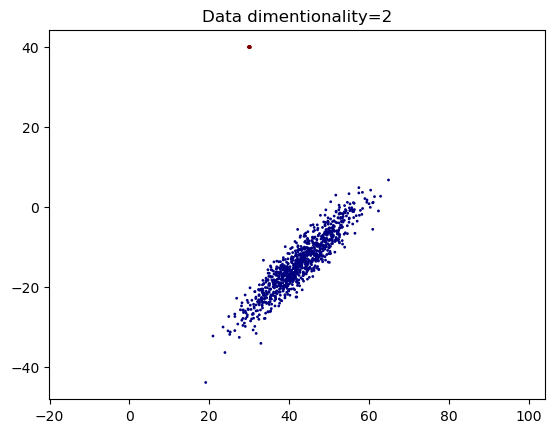

In [24]:
# Data matrix 
mat = scipy.io.loadmat('datasets/ellipsoide_robustpca.mat')
X = mat['X']
Xref = X
n = X.shape[0]
d = X.shape[1]
C_outliers = mat['C_outliers'].squeeze()
print(n,d)

plt.figure(1)
size_vertex_plot = 1
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n), c=C_outliers, color=pyplot.jet())
plt.title('Data dimentionality=' + str(d))
plt.axis('equal')
plt.show()


nb_pca: 2


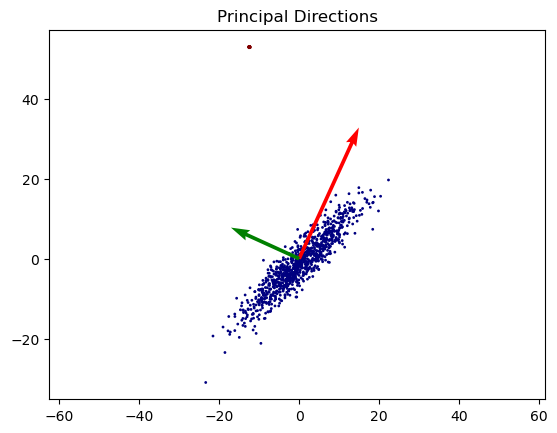

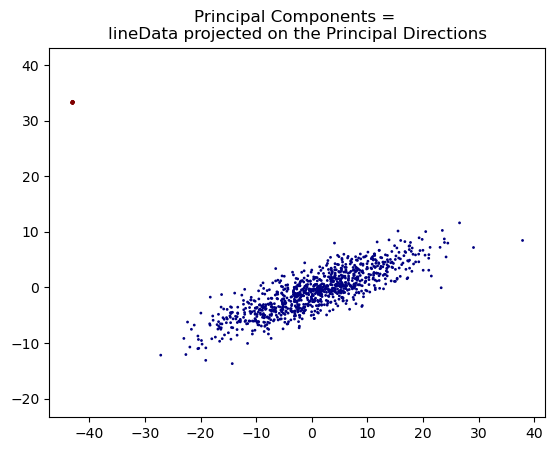

In [25]:
# Run standard PCA
nb_pca = 2
PC,PD,EnPD = compute_pca(X,nb_pca)

# zero-centered data
Xzc = X - np.mean(X,axis=0) 

# Plot
plt.figure(2)
size_vertex_plot = 1
plt.scatter(Xzc[:,0], Xzc[:,1], s=size_vertex_plot*np.ones(n), c=C_outliers, color=pyplot.jet())
k=0; p=-3e-4* EnPD[k]* PD[:,k]; p1pca = p
plt.quiver(0.0, 0.0, p[0], p[1], scale=1., units='xy', color='r') 
k=1; p=5e-4* EnPD[k]* PD[:,k]; p2pca = p
plt.quiver(0.0, 0.0, p[0], p[1], scale=1., units='xy', color='g') 
plt.title('Principal Directions')
plt.axis('equal')
#plt.xlim([-30, 30]); plt.ylim([-30, 60])
plt.show()

plt.figure(3)
size_vertex_plot = 1
plt.scatter(PC[:,0], PC[:,1], s=size_vertex_plot*np.ones(n), c=C_outliers, color=pyplot.jet())
plt.title('Principal Components = \nlineData projected on the Principal Directions')
plt.axis('equal')
plt.show()


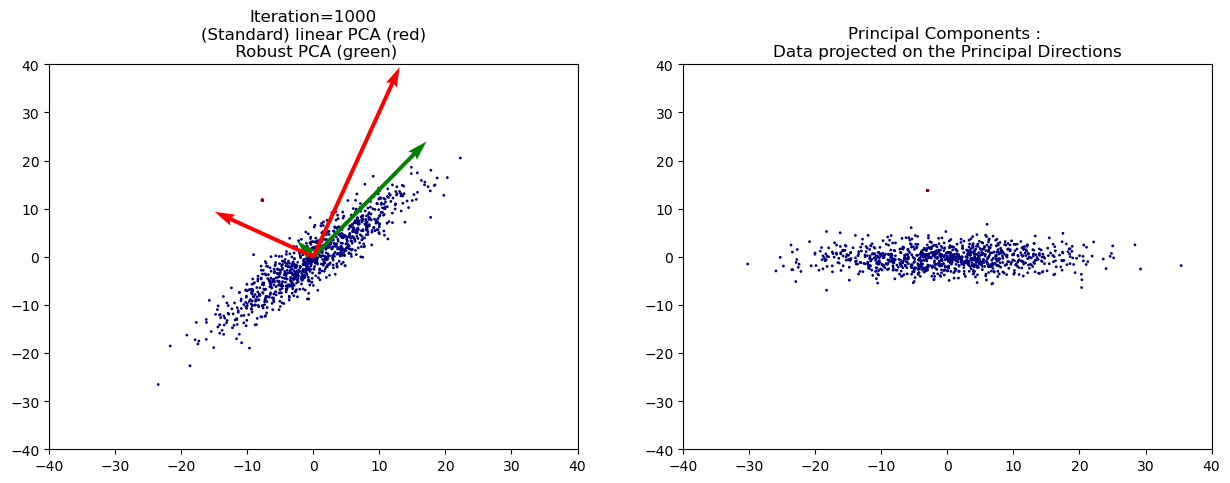

In [26]:
# Run Robust PCA
X = Xref - np.mean(Xref,axis=0) 
L = X
S = np.zeros(X.shape)
Z = np.zeros(X.shape)
n,m = X.shape
min_nm = np.min([n,m])
r = 1
lambdaN = 1.
lambdaS = 0.1
for i in range(1001):
    
    # Update L
    Lold = L
    L = X - S + Z/r
    Usvd, Ssvd, Vsvd = np.linalg.svd(L) # L = U*S*V'
    Sdiag = shrink( Ssvd , lambdaN/ r )
    I = np.array(range(min_nm))
    Sshrink = np.zeros([n,m])
    Sshrink[I,I] = Sdiag
    L = Usvd.dot(Sshrink.dot(Vsvd))
       
    # Update S
    Sold = S
    S = X - L + Z/r
    S = shrink( S , lambdaS/ r )
    
    # Update Z
    Z = Z + r * ( X - L - S )
    
    # Diff between two successive iterates
    diffL = np.linalg.norm(L-Lold,'fro')
    diffS = np.linalg.norm(S-Sold,'fro')
    
    # Display
    cpt = 100
    if not(i%cpt):
        
        # Run standard PCA on low-rank part, which is a denoised data matrix
        nb_pca = 2
        X_new = L
        X_new = X_new - np.mean(X_new,axis=0) 
        [PC,PD,EnPD] = compute_pca(X_new,nb_pca)
        
        # Plot
        clear_output(wait=True)
        fig = plt.figure(4, figsize=(15, 5))
        plt.subplot(121)        
        size_vertex_plot = 1
        if (i>=cpt): im1.remove(); im2.remove(); im3.remove(); im4.remove(); im5.remove(); im6.remove(); 
        im1 = plt.scatter(X_new[:,0], X_new[:,1], s=size_vertex_plot*np.ones(n), c=C_outliers, color=pyplot.jet())
        k=0; p=-3e-4* EnPD[k]* PD[:,k]; 
        im2 = plt.quiver(0.0, 0.0, p[0], p[1], scale=1., units='xy', color='g') 
        k=1; p=5e-4* EnPD[k]* PD[:,k]; 
        im3 = plt.quiver(0.0, 0.0, p[0], p[1], scale=1., units='xy', color='g') 
        im4 = plt.quiver(0.0, 0.0, p1pca[0], p1pca[1], scale=1., units='xy', color='r') 
        im5 = plt.quiver(0.0, 0.0, p2pca[0], p2pca[1], scale=1., units='xy', color='r') 
        plt.title('Iteration=' + str(i) + '\n(Standard) linear PCA (red)\n Robust PCA (green)')
        #plt.axis('equal')
        plt.xlim([-40, 40]); plt.ylim([-40, 40])
        plt.subplot(122)
        im6 = plt.scatter(PC[:,0], PC[:,1], s=size_vertex_plot*np.ones(n), c=C_outliers, color=pyplot.jet())
        plt.title('Principal Components : \nData projected on the Principal Directions')
        #plt.axis('equal')
        plt.xlim([-40, 40]); plt.ylim([-40, 40])
        plt.show()   
        time.sleep(0.1)
        